[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/stammler/ml_intro/HEAD?labpath=notebooks%2F3_clustering.ipynb)

# Clustering Algorithms

In this notebook we are trying to classify handwritten digits.

But first, we need to load the data. `sklearn` comes with a couple of example datasets.

In [1]:
from sklearn import datasets

In [2]:
X, y = datasets.load_digits(return_X_y=True)

`X` is our data. it contains 1797 digits with 64 pixels each.

In [3]:
X.shape

(1797, 64)

`y` are the labels that we can use for the training later.

In [4]:
y.shape

(1797,)

How do the digits look like?

When plotting them, we have to reshape the 64 pixels into an 8x8 image.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def plot_tiles(X, y=None, N=5, random=True):
    Ntot = N**2
    d = int(np.sqrt(X[0].shape[0]))
    if random:
        rndi = np.random.choice(np.arange(X.shape[0]), Ntot, replace=False)
    else:
        rndi = np.arange(Ntot)
    fig, ax = plt.subplots(N, N, dpi=150)
    for i in range(Ntot):
        ix = i // N
        iy = i % N
        img = X[rndi[i]].reshape(d, d)
        ax[ix, iy].imshow(img, cmap="Greys", vmax=X.max(), vmin=X.min())
        ax[ix, iy].axis("off")
        if y is not None:
            ax[ix, iy].set_title("{}".format(y[rndi[i]]), fontsize="small")
    fig.tight_layout()

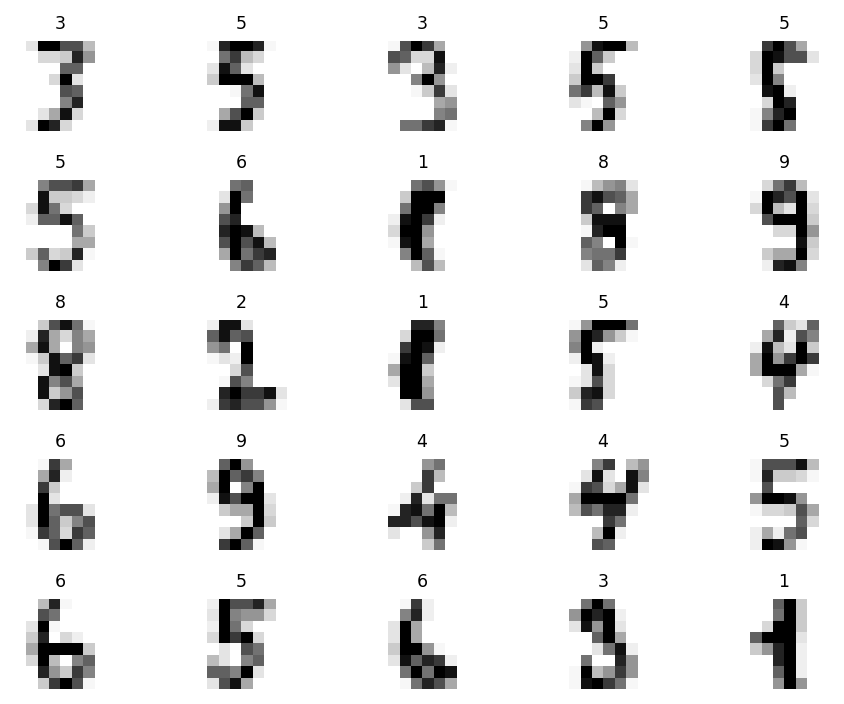

In [7]:
plot_tiles(X, y=y)

There is quite some variation within the same digits.

In [8]:
def plot_numbers(X, y, N):
    d = int(np.sqrt(X[0].shape[0]))
    fig, ax = plt.subplots(10, N, dpi=150)
    for ix in range(10):
        sub = X[y==ix, :]
        randi = np.random.choice(np.arange(sub.shape[0]), N, replace=False)
        for iy in range(N):
            ax[ix, iy].imshow(sub[randi[iy]].reshape(d, d), cmap="Greys", vmax=X.max(), vmin=X.min())
            ax[ix, iy].axis("off")
    fig.tight_layout()

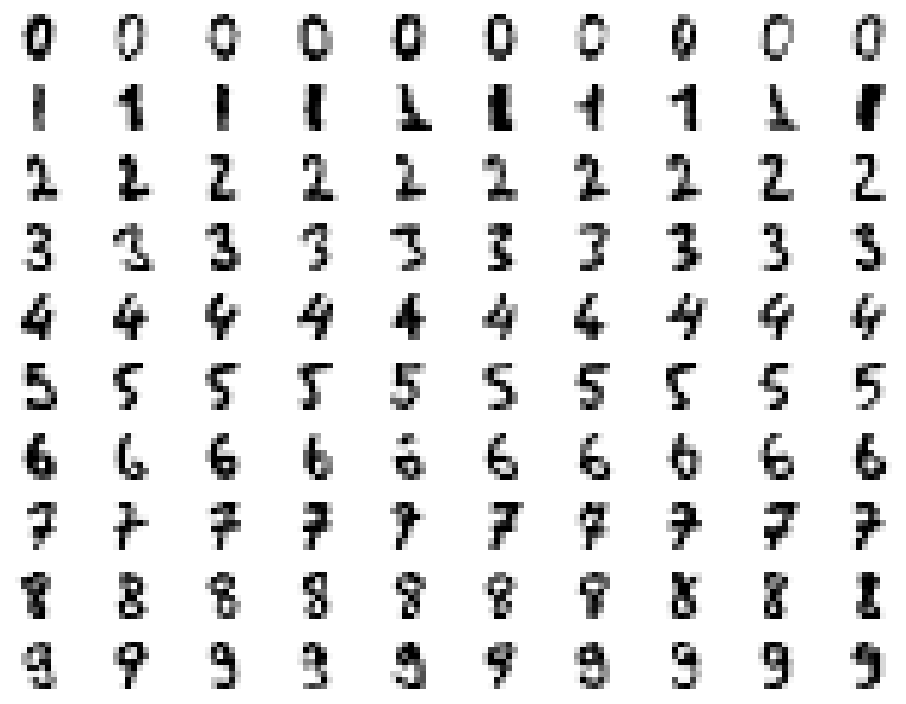

In [9]:
plot_numbers(X, y, 10)

As a first step before doing anything, we are going to split our data in a training set and a test data set. We are using the training set to train our model and the test data set for validation of the model. This will prevent "overfitting".

`sklearn` has a method for this. We are splitting out data in 80% testing and 20% validation.

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

In [12]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1437, 64), (1437,), (360, 64), (360,))

The method ensures that the data-labels association persists.

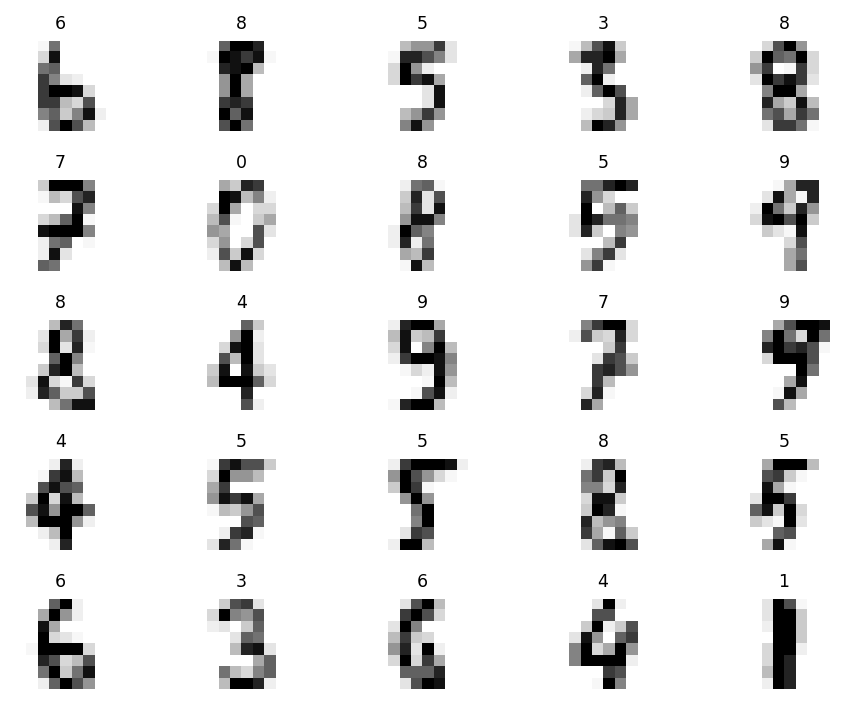

In [13]:
plot_tiles(X_train, y=y_train)

Let us first play around with the data and remove the mean value of every pixel.

In [14]:
X_mean = X_train.mean(0)
X_shift = X_train - X_mean

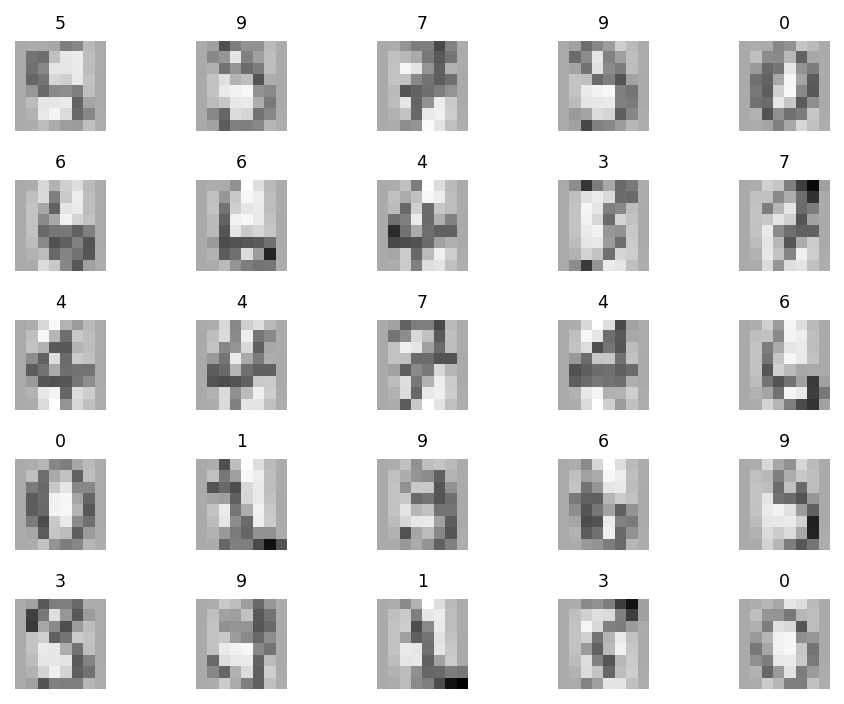

In [15]:
plot_tiles(X_shift, y=y_train)

And calculate the covariance matrix.

In [16]:
cov_X = np.cov(X_train.T)

In [17]:
def plot_cov(Sigma, title=None):
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111)
    ax.axis("off")
    plot = ax.imshow(Sigma, cmap="inferno", vmin=np.minimum(Sigma.min(), 0))
    cbar = plt.colorbar(plot)
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()

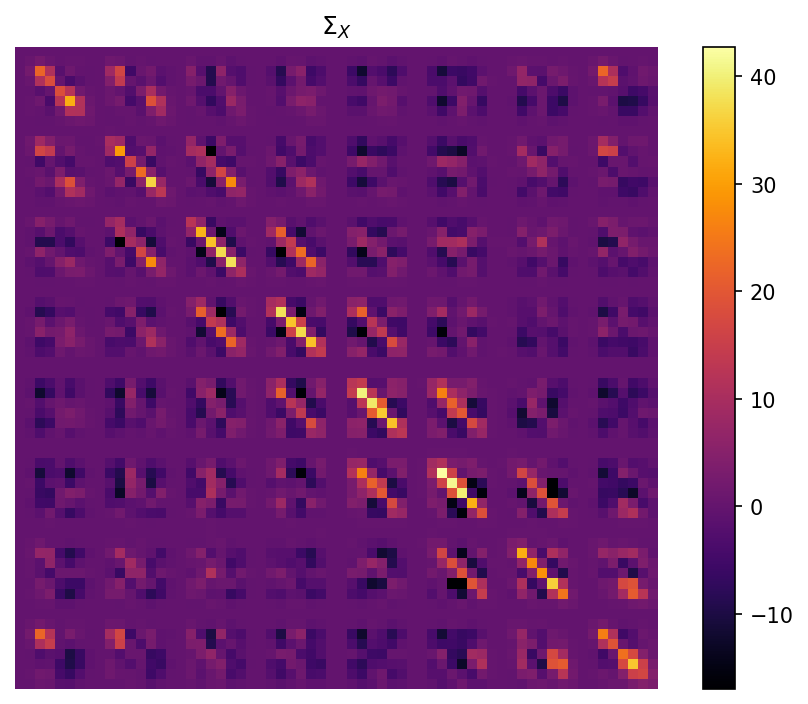

In [18]:
plot_cov(cov_X, title="$\Sigma_X$")

Let's do PCA on this.

In [19]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA()
Y_train = pca.fit_transform(X_train)

We can calculate the covariance matrix of our data in eigenspace.

In [21]:
cov_Y = np.cov(Y_train.T)

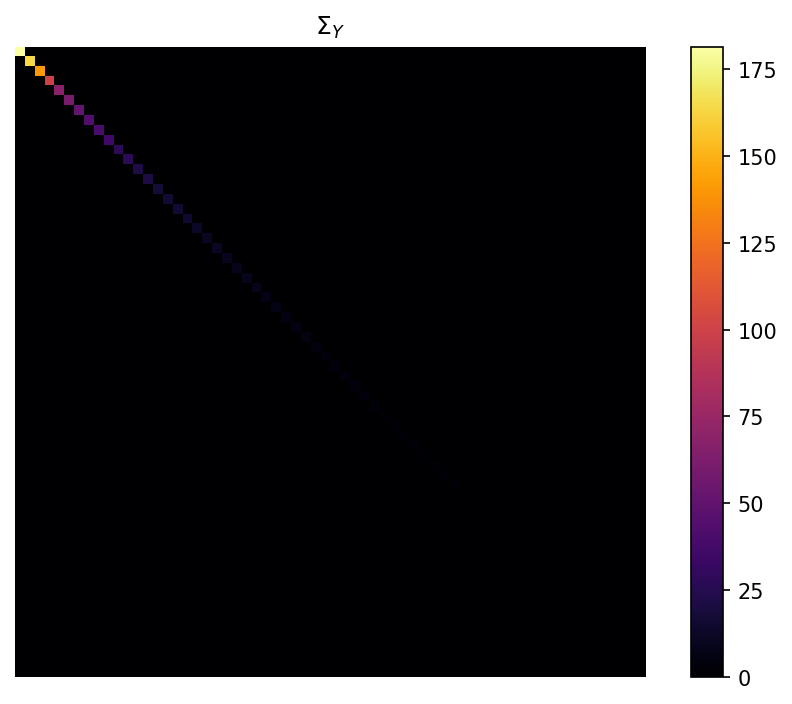

In [22]:
plot_cov(cov_Y, title="$\Sigma_Y$")

And we can check how the components contribute to the explained variance.

In [23]:
expl_var = pca.explained_variance_ratio_

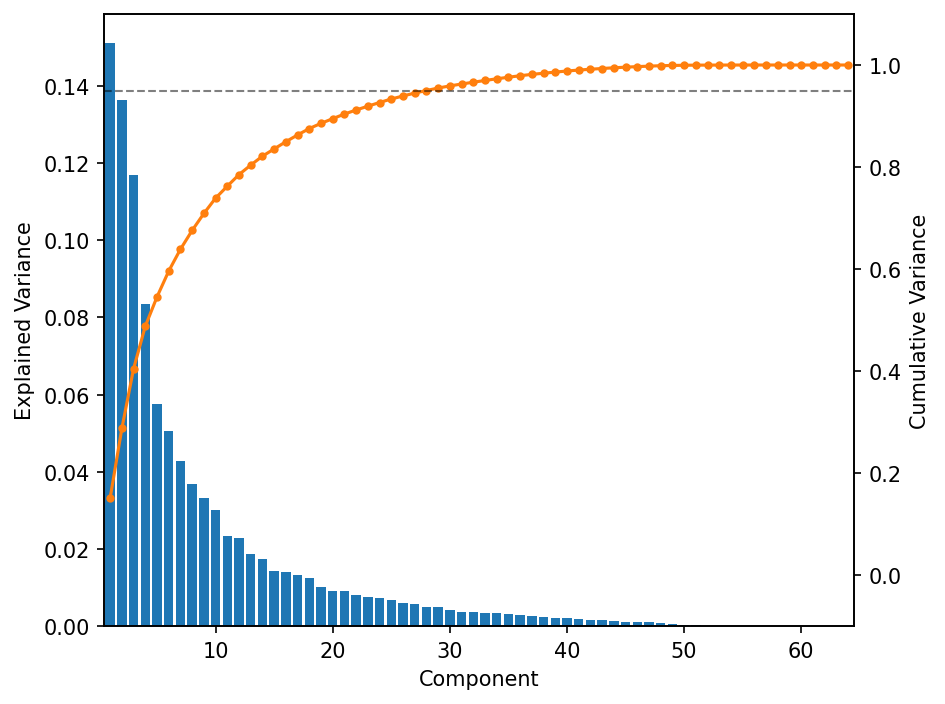

In [24]:
N = X.shape[1]
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111)
ax.bar(np.arange(N)+1, expl_var)
ax.set_xlabel("Component")
ax.set_ylabel("Explained Variance")
ax.set_xlim(0.5, N+0.5)
axr = ax.twinx()
axr.plot(np.arange(N)+1, expl_var.cumsum(), ".-", c="C1")
axr.axhline(0.95, ls="--", lw=1, c="black", alpha=0.5)
axr.set_ylabel("Cumulative Variance")
axr.set_ylim(-0.1, 1.1)
fig.tight_layout()

We can now also calculate how many components we would need to explain at least 95% of the variance.

In [25]:
iex95 = (expl_var.cumsum()>0.95).argmax()+1

In [26]:
from IPython.display import Markdown as md

In [27]:
msg = "To explain 95% of the variance we only need the first {} principal components instead of the full set of {} dimensions.".format(iex95, X.shape[1])
md(msg)

To explain 95% of the variance we only need the first 29 principal components instead of the full set of 64 dimensions.

We can transform our digit back, but only using the first few principal components to see how the numbers look like.

In [28]:
E = pca.components_.T
selector = np.zeros(X.shape[1])
selector[:iex95] = 1
E_red = E @ np.diag(selector)

In [29]:
X_red = Y_train @ E_red.T + X_mean

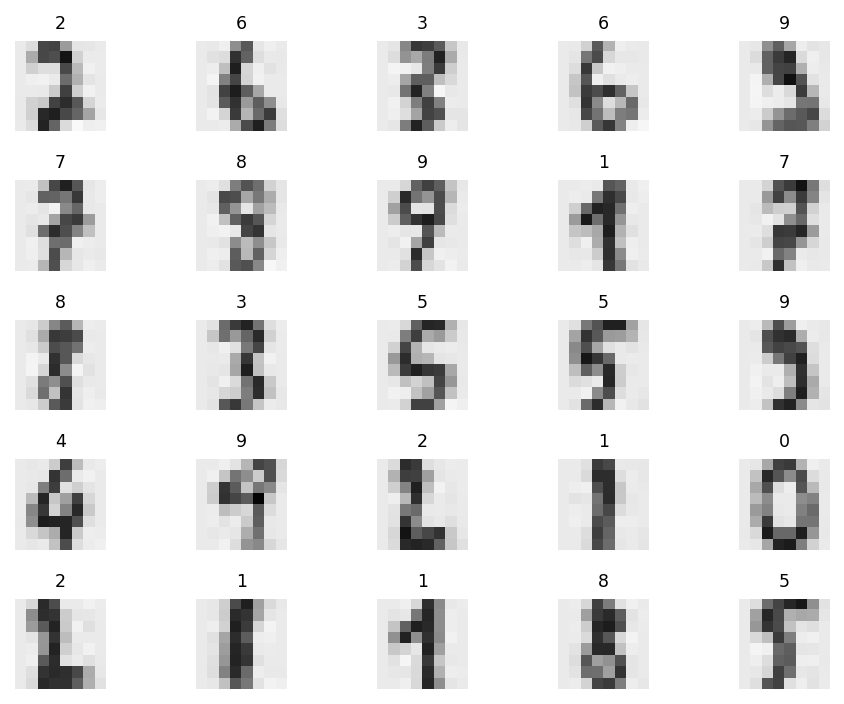

In [30]:
plot_tiles(X_red, y_train)

Additionally, we can plot how the first few "eigendigits" look like, the columns of the matrix $\mathbb{E}$.

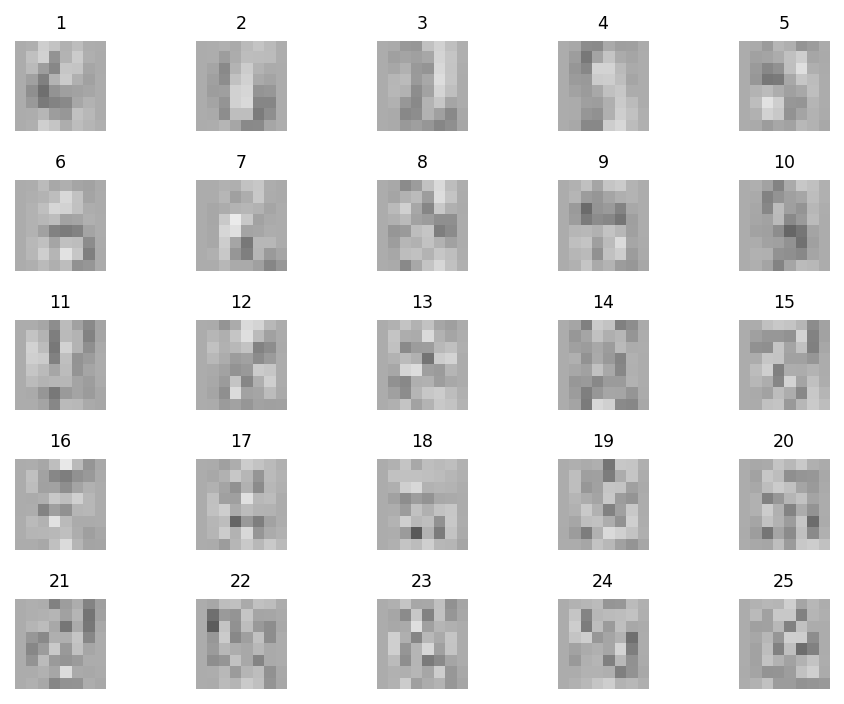

In [31]:
plot_tiles(E.T, np.arange(25)+1, random=False)

We can also check how the digits look like in the eigenspace.

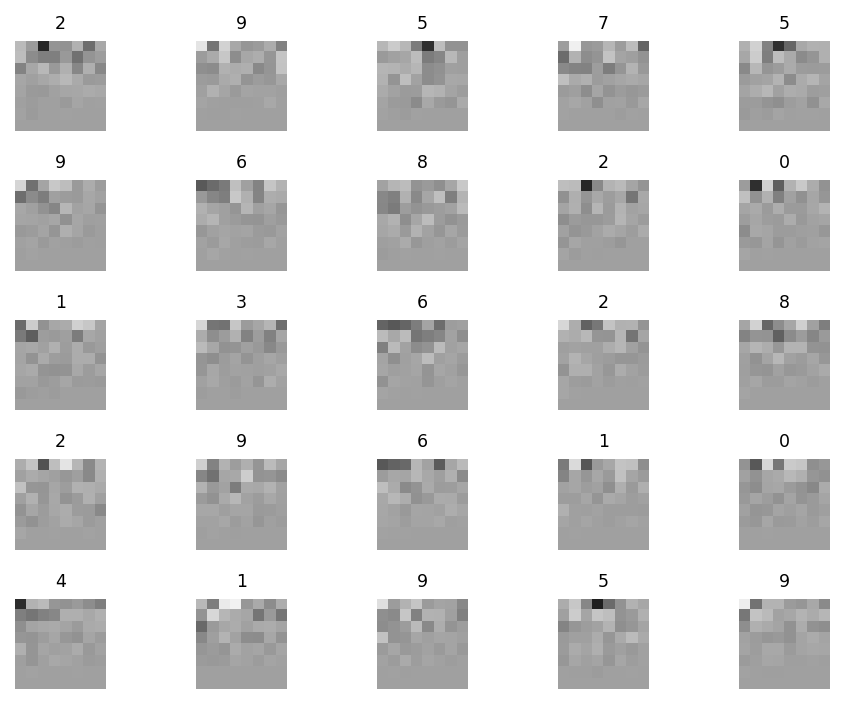

In [32]:
plot_tiles(Y_train, y_train)

And we can plot the digits only using the first few principal components to see after which component we start to recognize the digits.

In [33]:
def plot_component_wise(X, y, d=None):
    n, q = X.shape
    if d is not None:
        j = np.random.choice(np.arange(n)[y==d])
    else:
        j = np.random.randint(0, high=X.shape[0])
    X_comp = np.empty((n, q))
    for i in range(0, n):
        selector = np.zeros(q)
        selector[:i+1] = 1
        E_comp = E @ np.diag(selector)
        X_comp[i, :] = Y_train[j, :] @ E_comp.T
    plot_tiles(X_comp+X_mean, y=np.arange(n)+1, random=False)

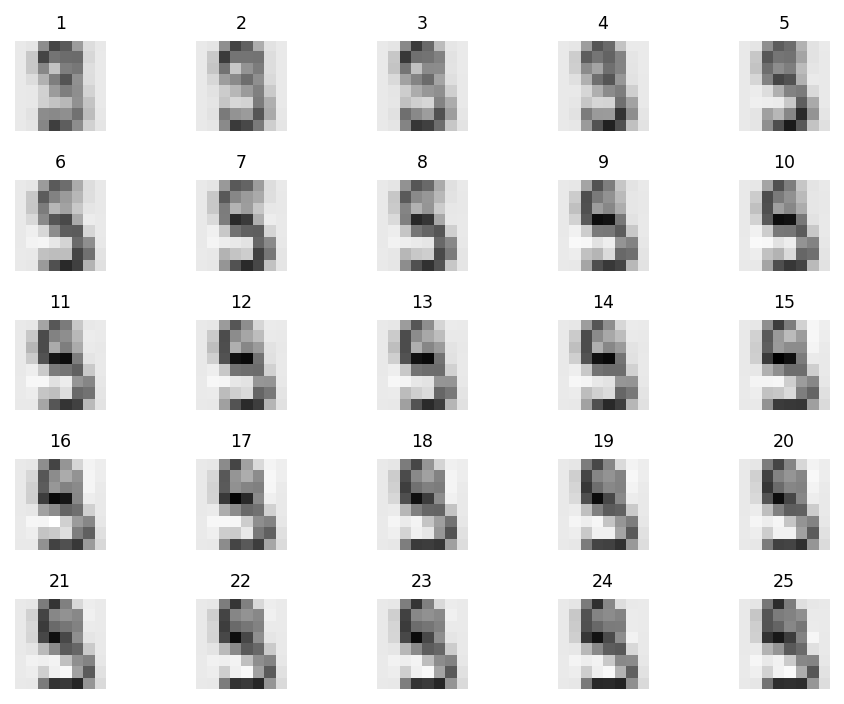

In [34]:
plot_component_wise(Y_train, y_train, d=9)

Let us now plot the first two principal components.

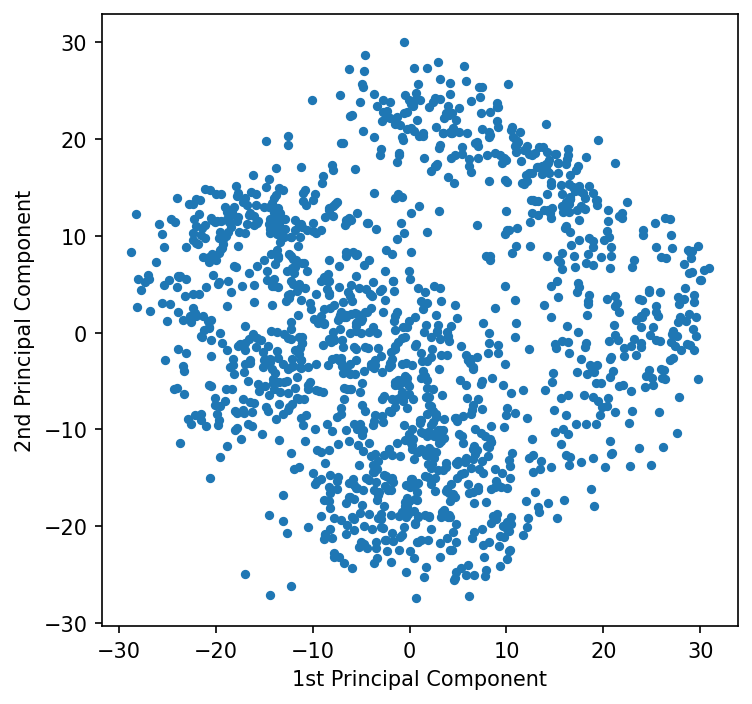

In [35]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], s=12)
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

And here color coded by their value.

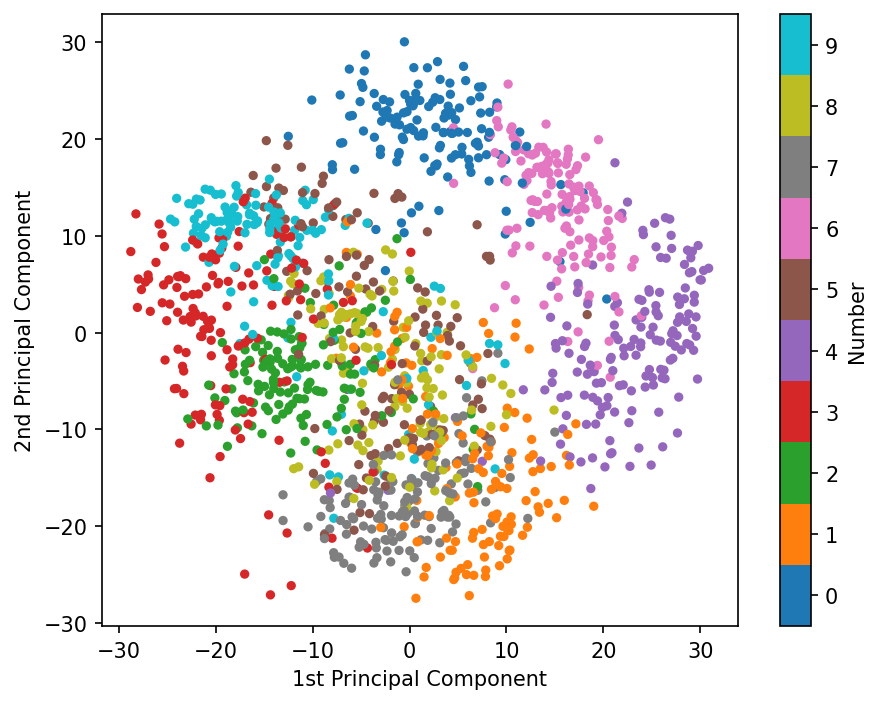

In [36]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=y_train, cmap="tab10", vmin=-0.5, vmax=9.5, s=12)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(np.arange(10))
cbar.ax.set_ylabel("Number")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

It can be seen that the digits are roughly clustered in the eigenspace. In order to classify the digits we have to find the clusters.  
For this, `sklearn` has a couple of clsuter finding algorithms implemented.

## k-means clustering

[k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering) is one of the simplest clustering algorithms. It works iteratively:

0. Define k cluster centers randomly<br /><br />
1. Associate all data points to the cluster to whose center they are closest
2. Compute the "center of mass" of all data points within a cluster and consider it the new cluster center.
3. Repeat from 1. until convergence

k-means clustering does not use the labels of the digits to identify the clusters. It is therefore considered **unsupervised learning**.

![](https://upload.wikimedia.org/wikipedia/commons/e/ea/K-means_convergence.gif)

`sklearn` has a method for this.  
We have to give it the number of clusters as input parameters. In our case this is 10, since we have 10 different digits. And we only use the first 28 principal components, which contain 95% of the total variance.

In [37]:
from sklearn.cluster import KMeans

In [38]:
kmeans_unsup = KMeans(n_clusters=10).fit(Y_train[:, :iex95])

After lerning we can access the "cluster labels" the algorithm assigned to our data points.

In [39]:
kmeans_unsup.labels_

array([7, 1, 9, ..., 1, 2, 1], dtype=int32)

We can plot the first principal components now color coded with the clusters they have been associated with.  
It looks remarkably similar to the actual clusters, however the labels are permuted, since the clustering alogrithm has no information about the actual labels.

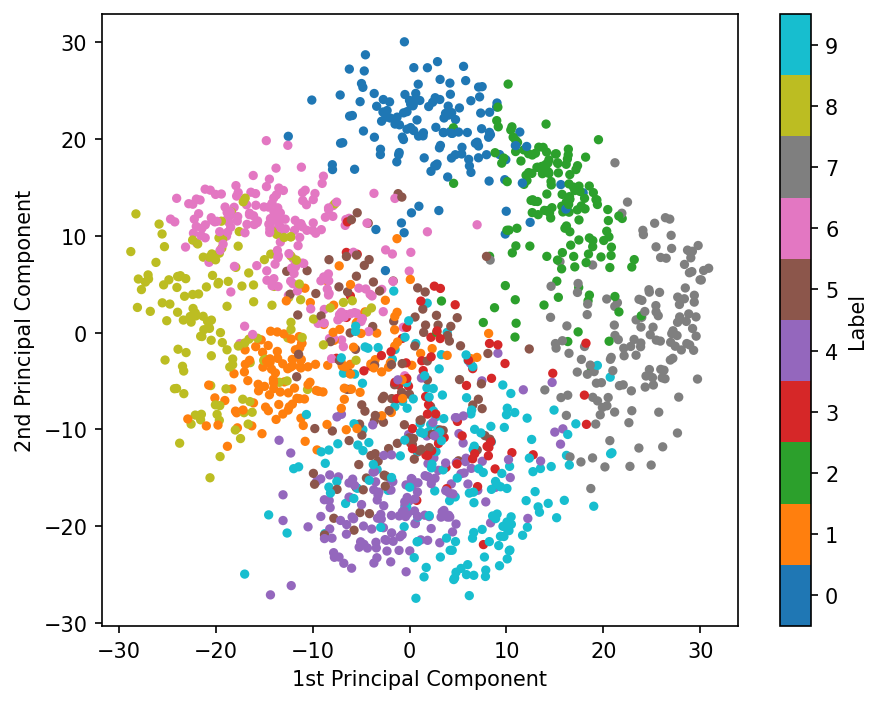

In [40]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=kmeans_unsup.labels_, cmap="tab10", vmin=-0.5, vmax=9.5, s=12)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(np.arange(10))
cbar.ax.set_ylabel("Label")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

It is now our task to find out which cluster label belongs to which digit.

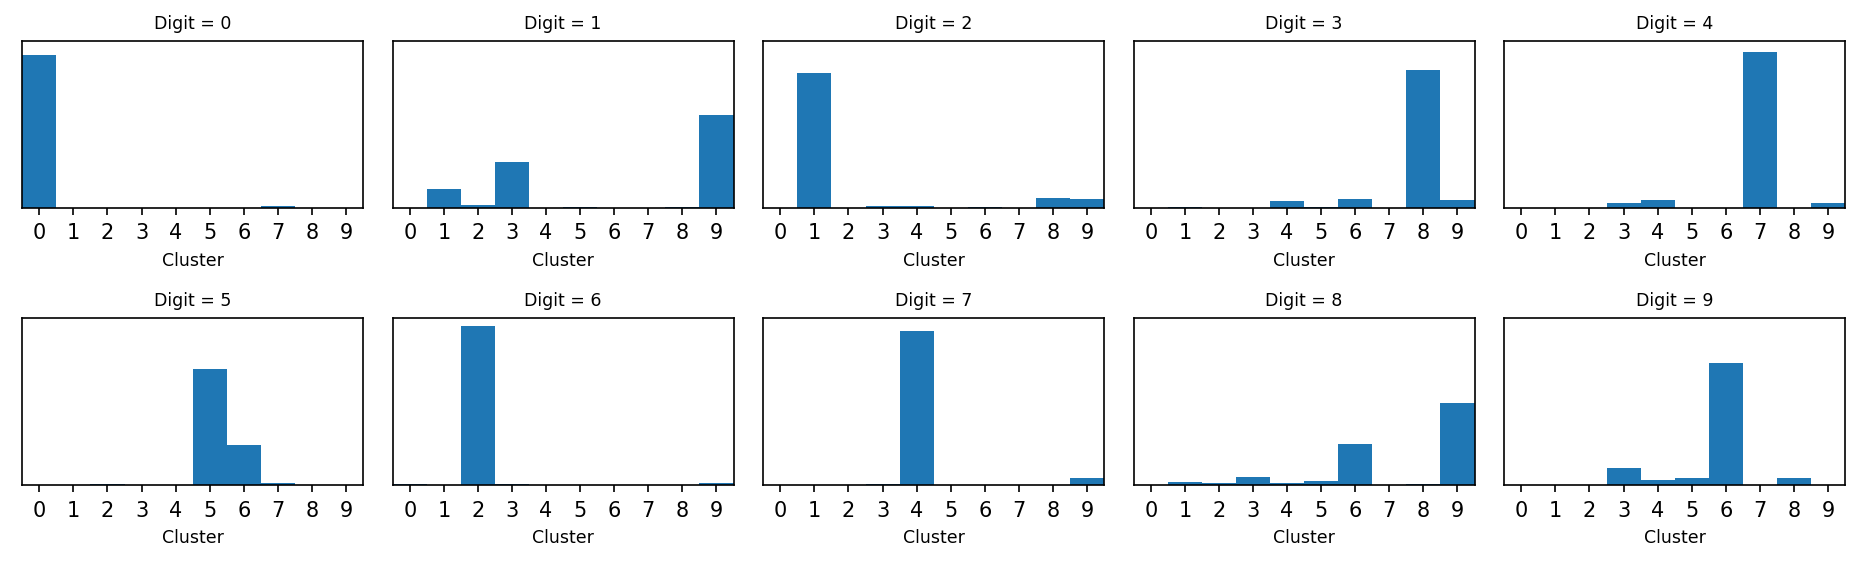

In [41]:
width = 2.5
height = width/1.3
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=150, figsize=(5*width, 2*height), sharey=True)
for i in range(10):
    ix = i // 5
    iy = i % 5
    ax[ix, iy].hist(kmeans_unsup.labels_[y_train==i], bins=np.arange(11)-0.5)
    ax[ix, iy].set_title("Digit = {}".format(i), fontsize="small")
    ax[ix, iy].set_xlim(-0.5, 9.5)
    ax[ix, iy].set_xticks(np.arange(10))
    ax[ix, iy].set_yticks([])
    ax[ix, iy].set_xlabel("Cluster", fontsize="small")
fig.tight_layout()

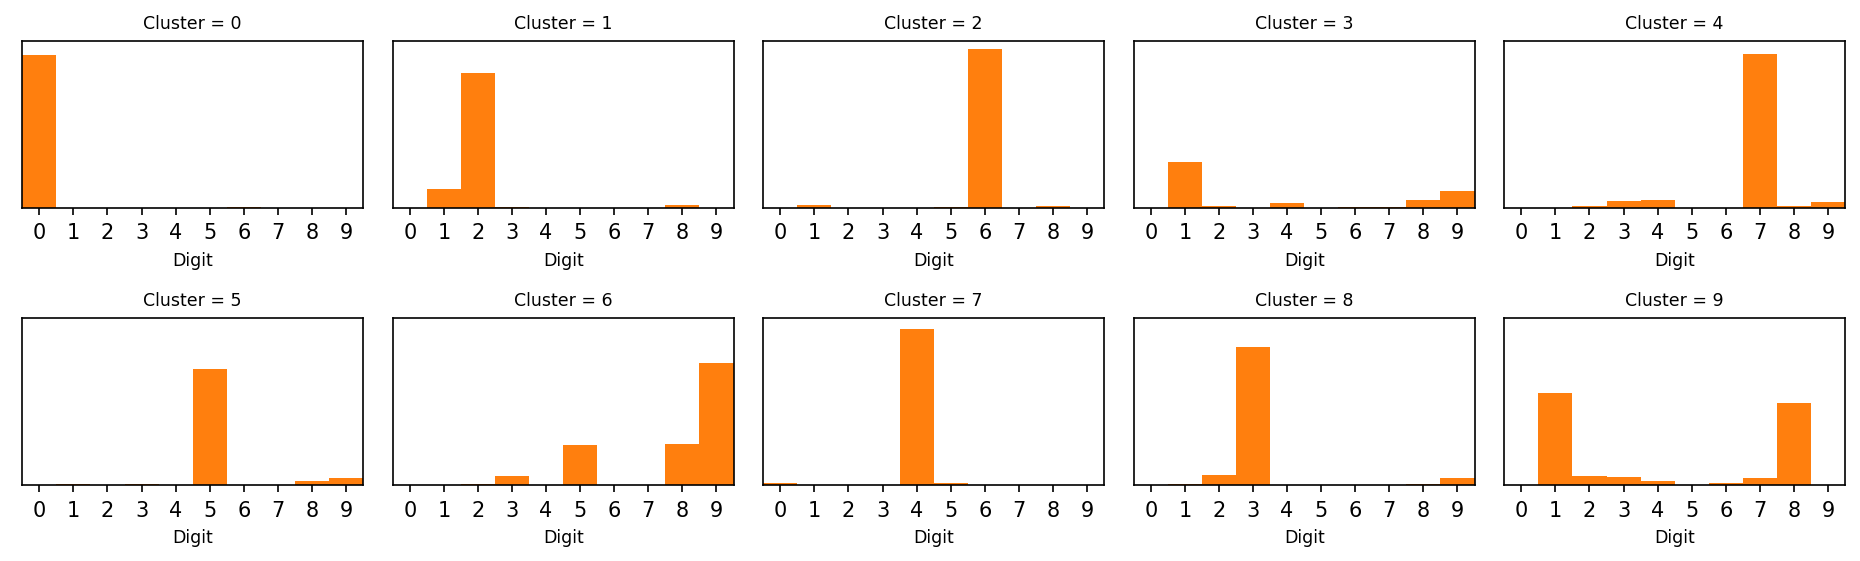

In [42]:
width = 2.5
height = width/1.3
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=150, figsize=(5*width, 2*height), sharey=True)
for i in range(10):
    ix = i // 5
    iy = i % 5
    ax[ix, iy].hist(y_train[kmeans_unsup.labels_==i], bins=np.arange(11)-0.5, color="C1")
    ax[ix, iy].set_title("Cluster = {}".format(i), fontsize="small")
    ax[ix, iy].set_xlim(-0.5, 9.5)
    ax[ix, iy].set_xticks(np.arange(10))
    ax[ix, iy].set_yticks([])
    ax[ix, iy].set_xlabel("Digit", fontsize="small")
fig.tight_layout()

We now assign every cluster to the digit that is most common in it.

In [65]:
from scipy import stats
label_map = {}
for i in range(10):
    label_map[i] = stats.mode(y_train[kmeans_unsup.labels_==i]).mode

/tmp/ipykernel_16229/938540865.py:4: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label_map[i] = stats.mode(y_train[kmeans_unsup.labels_==i]).mode


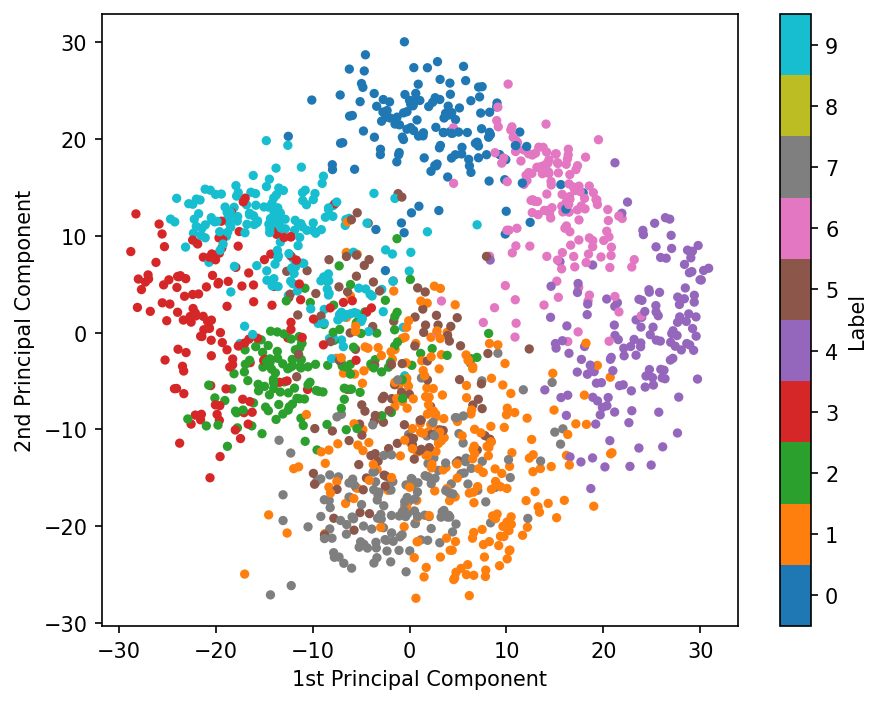

In [66]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=np.vectorize(label_map.get)(kmeans_unsup.labels_), cmap="tab10", vmin=-0.5, vmax=9.5, s=12)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(np.arange(10))
cbar.ax.set_ylabel("Label")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

We can now use `sklearn` to visualize the confusion matrix.

In [45]:
from sklearn.metrics import confusion_matrix

In [46]:
cmat_kmeans_unsup = confusion_matrix(y_train, np.vectorize(label_map.get)(kmeans_unsup.labels_), normalize="pred")

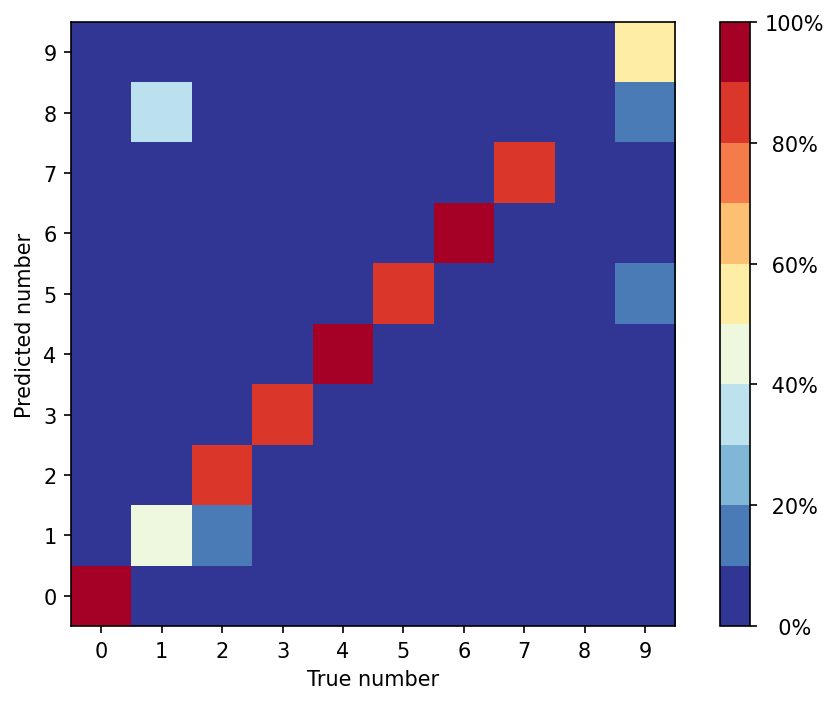

In [47]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot()
cmap = plt.get_cmap("RdYlBu_r", 10)
plot = ax.imshow(cmat_kmeans_unsup*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

But how well is our model performing on the test training set?  
Let's check!

First, we have to transform the test data set into the eigenspace.

In [48]:
Y_test = pca.transform(X_test)

And then get the labels from the K-Means Clustering.

In [49]:
kmeans_unsup_test = kmeans_unsup.predict(Y_test[:, :iex95])

In [50]:
cmat_kmeans_unsup_test = confusion_matrix(y_test, np.vectorize(label_map.get)(kmeans_unsup_test), normalize="pred")

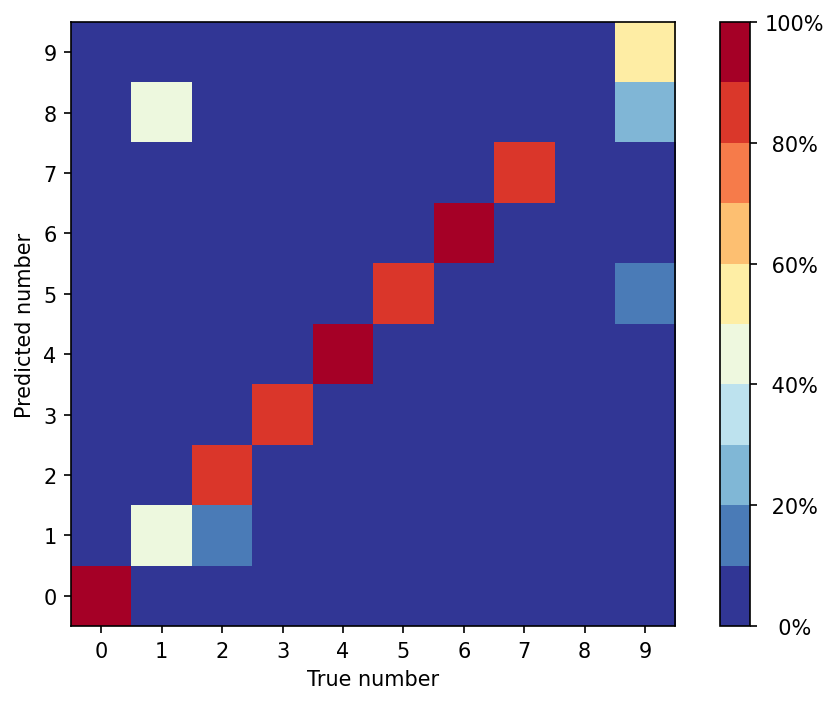

In [51]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot()
cmap = plt.get_cmap("RdYlBu_r", 10)
plot = ax.imshow(cmat_kmeans_unsup_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

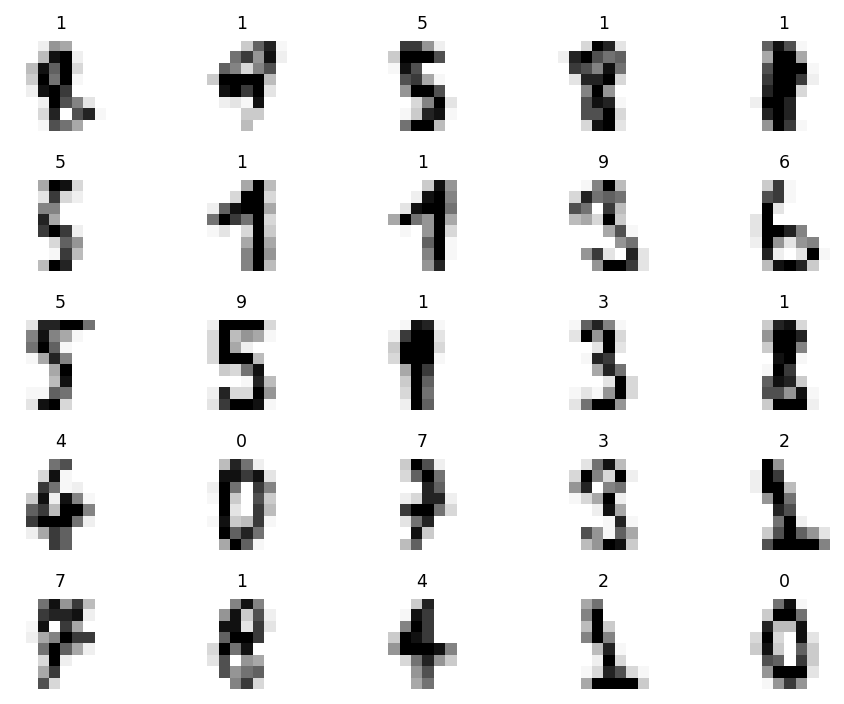

In [52]:
plot_tiles(X_test, np.vectorize(label_map.get)(kmeans_unsup_test))

We can now plot the overall accuracy of our model in the training set (filled) and the test set (open).
Both, training and test set, should perform equally good (or bad). If the training set is significantly better than the test set, then the model is overfitted.

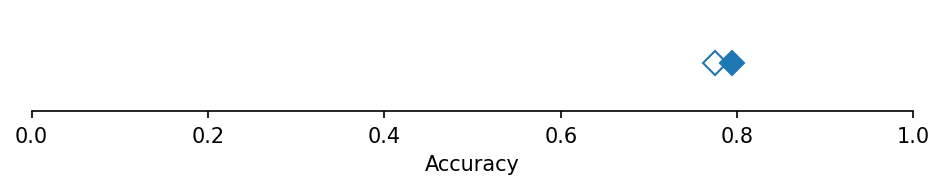

In [53]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
ax.plot((np.vectorize(label_map.get)(kmeans_unsup.labels_)==y_train).sum()/len(y_train), 0, "D", markersize=8, fillstyle="full", c="C0")
ax.plot((np.vectorize(label_map.get)(kmeans_unsup_test)==y_test).sum()/len(y_test), 0, "D", markersize=8, fillstyle="none", c="C0")
ax.set_xlim(0., 1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
fig.tight_layout()

But instead of letting the k-means clustering algorithm choose the initial cluster locations randomly, we could initialize the algorithm with the cluster centers from our training set.  
This is called **semi-supervised learning**.

In [54]:
kinit = []
for i in range(10):
    kinit.append(Y_train[y_train==i].mean(0)[:iex95])
kmeans_init = np.array(kinit)

In [55]:
kmeans_semi = KMeans(n_clusters=10, init=kmeans_init, n_init=1).fit(Y_train[:, :iex95])

Now the association of cluster labels to digits already works.

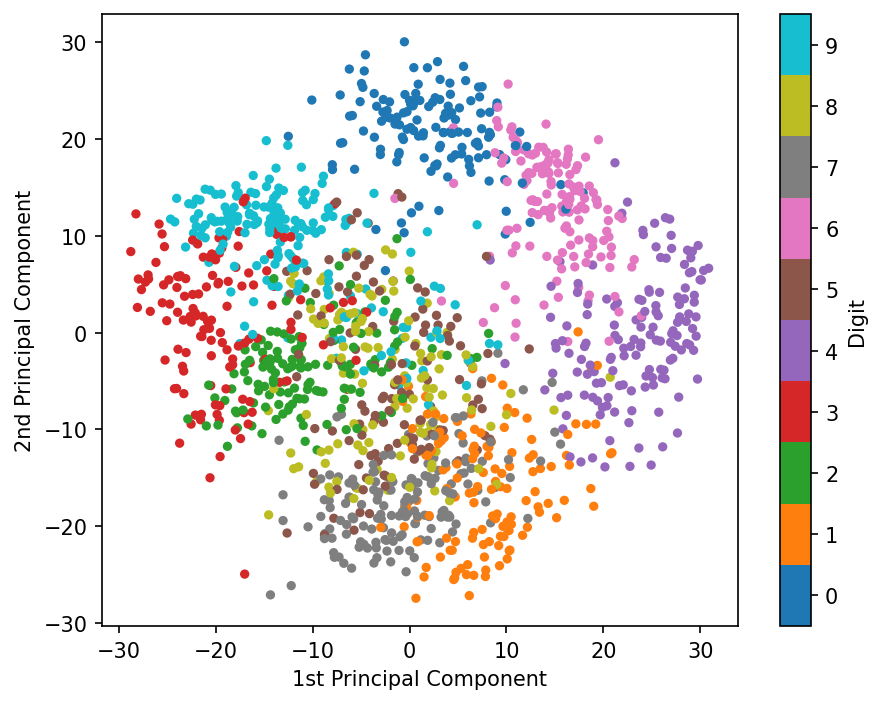

In [56]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
plot = ax.scatter(Y_train[:, 0], Y_train[:, 1], c=kmeans_semi.labels_, cmap="tab10", vmin=-0.5, vmax=9.5, s=12)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(np.arange(10))
cbar.ax.set_ylabel("Digit")
ax.set_xlabel("1st Principal Component")
ax.set_ylabel("2nd Principal Component")
fig.tight_layout()

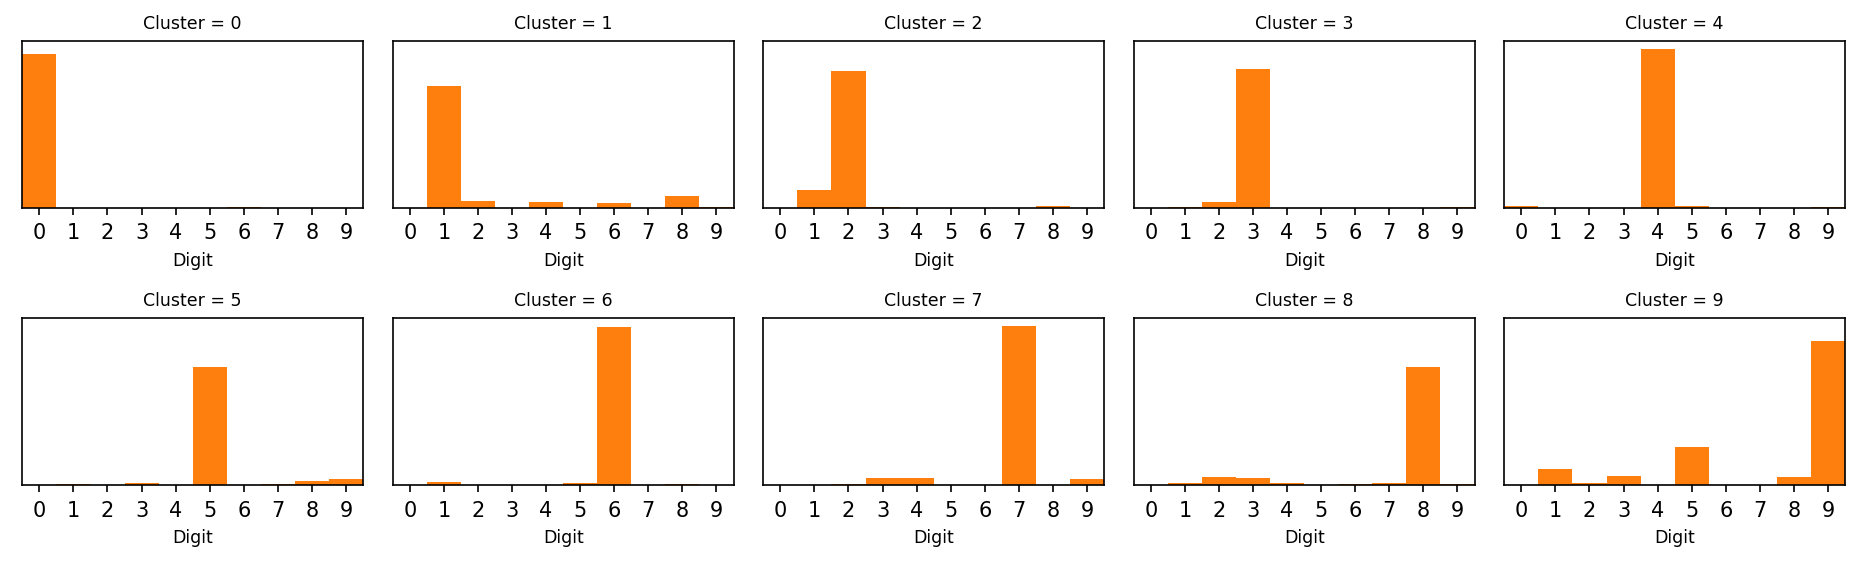

In [57]:
width = 2.5
height = width/1.3
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=150, figsize=(5*width, 2*height), sharey=True)
for i in range(10):
    ix = i // 5
    iy = i % 5
    ax[ix, iy].hist(y_train[kmeans_semi.labels_==i], bins=np.arange(11)-0.5, color="C1")
    ax[ix, iy].set_title("Cluster = {}".format(i), fontsize="small")
    ax[ix, iy].set_xlim(-0.5, 9.5)
    ax[ix, iy].set_xticks(np.arange(10))
    ax[ix, iy].set_yticks([])
    ax[ix, iy].set_xlabel("Digit", fontsize="small")
fig.tight_layout()

As before we can calucalte the confusion matrix.

In [58]:
cmat_kmeans_semi_train = confusion_matrix(y_train, kmeans_semi.labels_, normalize="pred")

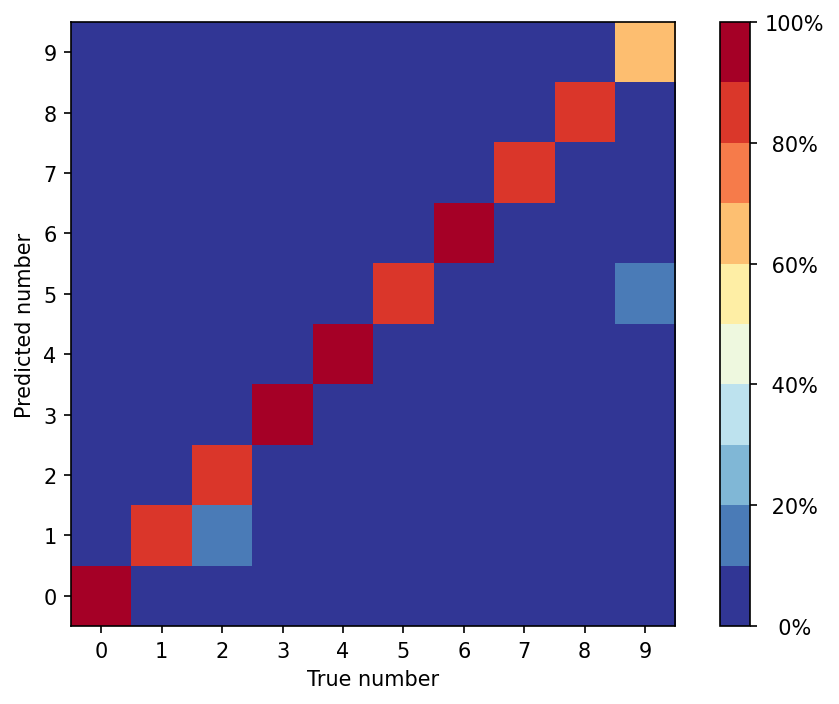

In [59]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot()
cmap = plt.get_cmap("RdYlBu_r", 10)
plot = ax.imshow(cmat_kmeans_semi_train*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

And we do the same for the test data set.

In [60]:
kmeans_semi_test = kmeans_semi.predict(Y_test[:, :iex95])

In [61]:
cmat_kmeans_semi_test = confusion_matrix(y_test, kmeans_semi_test, normalize="pred")

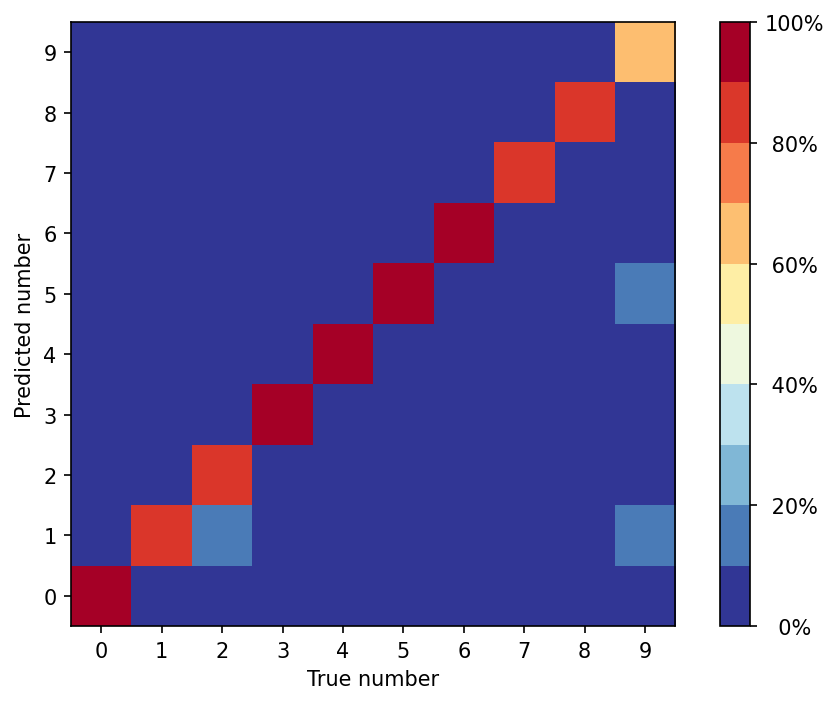

In [62]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot()
cmap = plt.get_cmap("RdYlBu_r", 10)
plot = ax.imshow(cmat_kmeans_semi_test*100, cmap=cmap, vmin=0, vmax=100)
cbar = plt.colorbar(plot, ax=ax)
cbar.ax.set_yticks(cbar.ax.get_yticks())
cbar.ax.set_yticklabels(["{:3.0f}%".format(proc) for proc in cbar.ax.get_yticks()])
ax.set_xticks(np.arange(10))
ax.set_yticks(np.arange(10))
ax.set_xlim(-0.5, 9.5)
ax.set_ylim(-0.5, 9.5)
ax.set_xlabel("True number")
ax.set_ylabel("Predicted number")
fig.tight_layout()

The overall performance of the semi-supervised algorithms is a bit better than the unsupervised version.

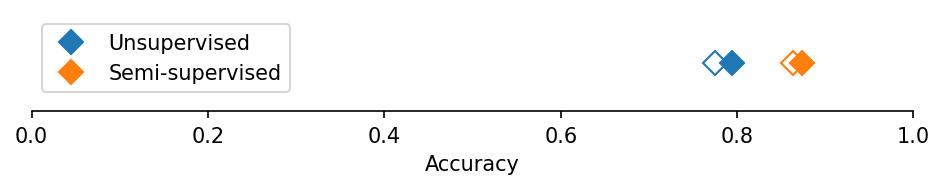

In [63]:
fig = plt.figure(dpi=150)
ax = fig.add_subplot(111, aspect=1)
ax.plot((np.vectorize(label_map.get)(kmeans_unsup.labels_)==y_train).sum()/len(y_train), 0, "D", markersize=8, fillstyle="full", c="C0", label="Unsupervised")
ax.plot((np.vectorize(label_map.get)(kmeans_unsup_test)==y_test).sum()/len(y_test), 0, "D", markersize=8, fillstyle="none", c="C0")
ax.plot((kmeans_semi.labels_==y_train).sum()/len(y_train), 0, "D", markersize=8, fillstyle="full", c="C1", label="Semi-supervised")
ax.plot((kmeans_semi_test==y_test).sum()/len(y_test), 0, "D", markersize=8, fillstyle="none", c="C1")
ax.set_xlim(0., 1)
ax.set_xlabel("Accuracy")
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_yticks([])
ax.legend(loc="upper left")
fig.tight_layout()

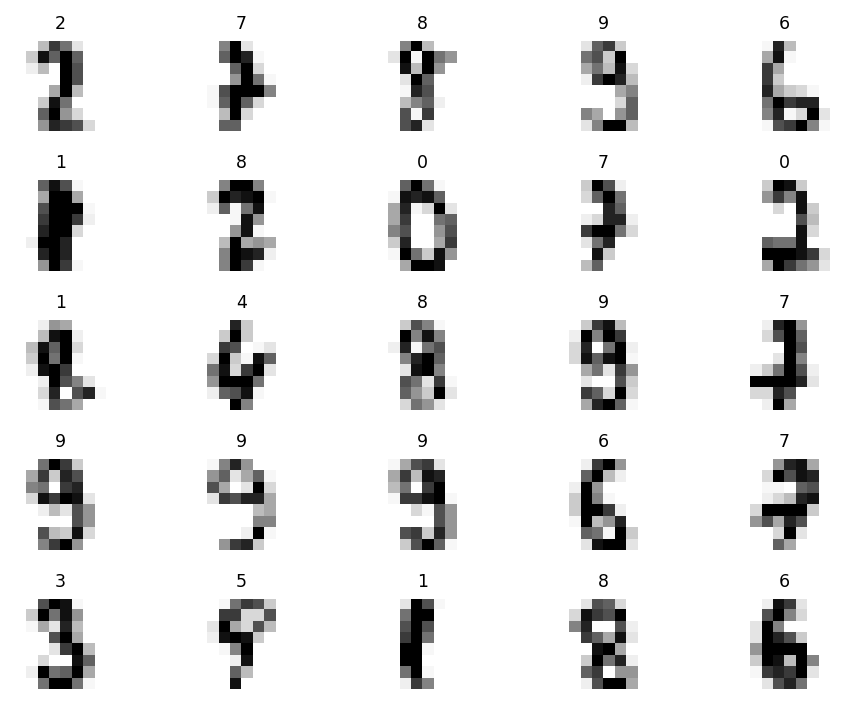

In [64]:
plot_tiles(X_test, y=kmeans_semi_test)

### Other cluster algorithms

`sklearn` comes with a couple of other cluster finding algorithms that all hyve their advantages and disadvantages depending on the problem.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png)